In [1]:
BRANCH = 'main'

"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""

'\nYou can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.\n\nInstructions for setting up Colab are as follows:\n1. Open a new Python 3 notebook.\n2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)\n3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)\n4. Run this cell to set up dependencies.\n'

In [2]:
import os
# either provide a path to local NeMo repository with NeMo already installed or git clone

# option #1: local path to NeMo repo with NeMo already installed
NEMO_DIR_PATH = os.path.dirname(os.path.dirname(os.path.abspath('')))
is_colab = False

# option #2: download NeMo repo
if 'google.colab' in str(get_ipython()) or not os.path.exists(os.path.join(NEMO_DIR_PATH, "nemo")):
    ## Install dependencies
    !apt-get install sox libsndfile1 ffmpeg

    !git clone -b $BRANCH https://github.com/NVIDIA/NeMo
    %cd NeMo
    !python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
    NEMO_DIR_PATH = os.path.abspath('')
    is_colab = True

import sys
sys.path.insert(0, NEMO_DIR_PATH)

In [3]:
## create data directory and download an audio file
WORK_DIR = 'WORK_DIR'
DATA_DIR = WORK_DIR + '/DATA'
os.makedirs(DATA_DIR, exist_ok=True)

print('downloading audio data...')
!python $NEMO_DIR_PATH/scripts/dataset_processing/get_librispeech_data.py --data_root=$DATA_DIR --data_set=test_other
!rm $DATA_DIR/test_other.tar.gz

downloading audio data...
100%|████████████████████████████████████████| 314M/314M [00:04<00:00, 79.5MB/s]
100%|███████████████████████████████████████████| 90/90 [00:04<00:00, 19.94it/s]


In [4]:
import json
import os
from termcolor import colored
from typing import List, Optional, Tuple, Union

from IPython.display import Audio, HTML, Image, display
import numpy as np
import texterrors

def get_detailed_wer_labels(ref: List[str], hyp: List[str], return_eps_padded_hyp: bool = False):
    """Get detailed WER labels, aligning reference with hypothesis.
    
    Possible WER labels:
        - 'C' for Correct,
        - 'I' for Insertion,
        - 'D' for Deletion,
        - 'S' for Substitution.

    Returns:
        WER labels list.
        [Optional] Epsilin-padded hypothesis if return_eps_padded_hyp set to True.
    """

    # Align reference and hypothesis using "<eps>"
    aligned_ref, aligned_hyp = texterrors.align_texts(ref, hyp, False)[:-1]

    # Determine labels
    labels = []
    for r, h in zip(aligned_ref, aligned_hyp):
        if r == h:
            labels.append("C")
        elif r == "<eps>":
            labels.append("I")
        elif h == "<eps>":
            labels.append("D")
        else:
            labels.append("S")

    return labels if not return_eps_padded_hyp else labels, aligned_hyp


def fill_confidence_deletions(confidence_scores: List[float], labels: List[str], fill_value: float = 0.0):
    """Fill confidence scores list with the provided value for deletions.
    Assumes that we have no natural confidence scores for deletions.
    
    Returns:
        Confidence scores list with deletion scores.
    """

    assert len(confidence_scores) <= len(labels)

    # If the lengths of confidence_scores and labels are equal, then we assume that there are no deletions
    if len(confidence_scores) == len(labels):
        return confidence_scores

    # Insert fill_value into confidence_scores where label == "D"
    new_confidence_scores = []
    score_index = 0
    for label in labels:
        if label == "D":
            new_confidence_scores.append(fill_value)
        else:
            new_confidence_scores.append(confidence_scores[score_index])
            score_index += 1
    return new_confidence_scores


def pretty_pad_word_labels(labels: List[str], words: List[str]):
    """Pad word labels with dash for pretty printing.
    Expects labels and words to have the same length.
    
    Returns:
        Padded labels list.
    """
    
    # Check that words and labels without 'D' have the same length
    assert len(words) == len(labels)

    # Pad the labels with dashes to align them with the words
    padded_labels = []
    for word, label in zip(words, labels):
        label_len = len(word)
        left_padding = (label_len - 1) // 2
        right_padding = label_len - left_padding - 1
        padded_label = "-" * left_padding + label + "-" * right_padding
        padded_labels.append(padded_label)

    return padded_labels


def _html_paint_word_grey(word: str, shade: str):
    if shade == "black":
        color = "0,0,0"
    elif shade == "grey":
        color = "150,150,150"
    elif shade == "light_grey":
        color = "200,200,200"
    else:
        raise ValueError(
            f"`shade` has to be one of the following: `black`, `grey`, `light_grey`. Provided: `{shade}`"
        )
    return f'<mark style="color:rgb({color});background-color:rgb(255,255,255);">{word}</font></mark>'


def pretty_print_transcript_with_confidence(
    transcript: str,
    confidence_scores: List[float],
    threshold: float,
    reference: Optional[str] = None,
    terminal_width: int = 120,
    html: bool = False,
):
    if html:
        shade_if_low_confidence = lambda x, y: _html_paint_word_grey(x, 'light_grey' if y < threshold else 'black')
        new_line_mark = "<br>"
        pretty_print = lambda x: display(HTML("<code>" + new_line_mark.join(x) + "</code>"))
    else:
        shade_if_low_confidence = lambda x, y: colored(x, 'light_grey') if y < threshold else x
        new_line_mark = "\n"
        pretty_print = lambda x: print(new_line_mark.join(x))
    with_labels = reference is not None
    transcript_list = transcript.split()
    output_lines = []
    if with_labels:
        reference_list = reference.split()
        labels, eps_padded_hyp = get_detailed_wer_labels(reference_list, transcript_list, True)
        padded_labels = pretty_pad_word_labels(labels, eps_padded_hyp)
        current_line_len = 0
        current_word_line = ""
        current_label_line = ""
        for word, label, padded_label, score in zip(
            eps_padded_hyp, labels, padded_labels, fill_confidence_deletions(confidence_scores, labels)
        ):
            word_len = len(word)
            # shield angle brackets for <eps>
            if html and word == "<eps>":
                word = "&lt;eps&gt;"
            if current_line_len + word_len + 1 <= terminal_width:
                if current_line_len > 0:
                    current_line_len += 1
                    current_word_line += " "
                    current_label_line += "-"
                current_line_len += word_len
                current_word_line += shade_if_low_confidence(word, score)
                current_label_line += padded_label
            else:
                output_lines.append(current_word_line + new_line_mark + current_label_line)
                current_line_len = word_len
                current_word_line = shade_if_low_confidence(word, score)
                current_label_line = padded_label
        if current_word_line:
            output_lines.append(current_word_line + new_line_mark + current_label_line)
    else:
        current_line_len = 0
        current_word_line = ""
        for word, score in zip(transcript_list, confidence_scores):
            word_len = len(word)
            # shield angle brackets for <eps>
            if html and word == "<eps>":
                word = "&lt;eps&gt;"
            if current_line_len + word_len + 1 <= terminal_width:
                if current_line_len > 0:
                    current_line_len += 1
                    current_word_line += " "
                current_line_len += word_len
                current_word_line += shade_if_low_confidence(word, score)
            else:
                output_lines.append(current_word_line)
                current_line_len = word_len
                current_word_line = shade_if_low_confidence(word, score)
        if current_word_line:
            output_lines.append(current_word_line)

    pretty_print(output_lines)

In [28]:
from dataclasses import dataclass
from omegaconf import DictConfig, OmegaConf

from nemo.collections.asr.models import ASRModel

def load_model(name: str):
    """Load a pre-trained model.

    Args:
        name: Pre-trained model name.
            Reserved names:
            - 'ctc' for 'stt_en_conformer_ctc_large_ls'
            - 'rnnt' for 'stt_en_conformer_transducer_large_ls'

    Returns:
        A model loaded into GPU with .eval() mode set.
    """
    if name == "ctc":
        name = "stt_en_conformer_ctc_large_ls"
    elif name == "rnnt":
        name = "stt_en_conformer_transducer_large_ls"

    model = ASRModel.from_pretrained(model_name=name, map_location="cuda:0")
    model.eval()

    return model

@dataclass
class TestSet:
    filepaths: List[str]
    reference_texts: List[str]
    durations: List[float]

def load_data(manifest_path: str):
    filepaths = []
    reference_texts = []
    durations = []
    with open(manifest_path, "r") as f:
        for line in f:
            item = json.loads(line)
            audio_file = item["audio_filepath"]
            filepaths.append(str(audio_file))
            text = item["text"]
            reference_texts.append(text)
            durations.append(float(item["duration"]))
    return TestSet(filepaths, reference_texts, durations)

TEST_MANIFESTS = {
    "test_other": DATA_DIR + "/test_other.json",
}


# Load data
test_sets = {manifest: load_data(path) for manifest, path in TEST_MANIFESTS.items()}

# Load model
is_rnnt = False
#is_rnnt = True

model = load_model("rnnt" if is_rnnt else "ctc")

[NeMo I 2024-09-16 11:50:26 cloud:58] Found existing object /home/user01/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo.
[NeMo I 2024-09-16 11:50:26 cloud:64] Re-using file from: /home/user01/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo
[NeMo I 2024-09-16 11:50:26 common:826] Instantiating model from pre-trained checkpoint
[NeMo I 2024-09-16 11:50:32 mixins:173] Tokenizer SentencePieceTokenizer initialized with 128 tokens


[NeMo W 2024-09-16 11:50:32 modelPT:176] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data/Librispeech_SP_Tarred/tarred_audio_manifest.json
    sample_rate: 16000
    batch_size: 16
    shuffle: true
    num_workers: 8
    pin_memory: true
    use_start_end_token: false
    trim_silence: false
    max_duration: 16.7
    min_duration: 0.1
    shuffle_n: 2048
    is_tarred: true
    tarred_audio_filepaths: /data/Librispeech_SP_Tarred/audio__OP_0..511_CL_.tar
    
[NeMo W 2024-09-16 11:50:32 modelPT:183] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    manifest_filepath:
    - /manifests/librispeech/librivox-dev-other.json
    - /manife

[NeMo I 2024-09-16 11:50:32 features:305] PADDING: 0


[NeMo W 2024-09-16 11:50:33 nemo_logging:349] /home/user01/NeMo/nemo/core/connectors/save_restore_connector.py:682: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
      return 

[NeMo I 2024-09-16 11:50:33 save_restore_connector:275] Model EncDecCTCModelBPE was successfully restored from /home/user01/.cache/torch/NeMo/NeMo_2.0.0rc2/stt_en_conformer_ctc_large_ls/1ea6a779af1742c38ff9945aa70b3dc3/stt_en_conformer_ctc_large_ls.nemo.


In [29]:
from nemo.collections.asr.parts.submodules.rnnt_decoding import RNNTDecodingConfig
from nemo.collections.asr.parts.submodules.ctc_decoding import CTCDecodingConfig
from nemo.collections.asr.parts.utils.asr_confidence_utils import (
    ConfidenceConfig,
    ConfidenceConstants,
    ConfidenceMethodConfig,
    ConfidenceMethodConstants,
)
from nemo.collections.asr.parts.utils.asr_confidence_benchmarking_utils import (
    apply_confidence_parameters,
    get_correct_marks,
    get_token_targets_with_confidence,
    get_word_targets_with_confidence,
)


# List allowed options for ConfidenceMethodConfig and ConfidenceConfig
print(f"Allowed options for ConfidenceMethodConfig: {ConfidenceMethodConstants.print()}\n")
print(f"Allowed options for ConfidenceConfig: {ConfidenceConstants.print()}\n")

# Initialize ConfidenceConfig and ConfidenceMethodConfig
confidence_cfg = ConfidenceConfig(
    preserve_frame_confidence=True, # Internally set to true if preserve_token_confidence == True
    # or preserve_word_confidence == True
    preserve_token_confidence=True, # Internally set to true if preserve_word_confidence == True
    preserve_word_confidence=True,
    aggregation="min", # How to aggregate frame scores to token scores and token scores to word scores
    exclude_blank=False, # If true, only non-blank emissions contribute to confidence scores
    tdt_include_duration=False, # If true, calculate duration confidence for the TDT models
    method_cfg=ConfidenceMethodConfig( # Config for per-frame scores calculation (before aggregation)
        name="entropy", # Or "entropy" (default), which usually works better
        entropy_type="tsallis", # Used only for name == "entropy". Recommended: "tsallis" (default) or "renyi"
        alpha=0.33, # Low values (<1) increase sensitivity, high values decrease sensitivity
        entropy_norm="exp" # How to normalize (map to [0,1]) entropy. Default: "exp"
    )
)

# Alternalively, look at ConfidenceConfig's docstring
print(f"More info on ConfidenceConfig here:\n{ConfidenceConfig().__doc__}\n")

# Put the created ConfidenceConfig into the model decoding config via .change_decoding_strategy()
model.change_decoding_strategy(
    RNNTDecodingConfig(fused_batch_size=-1, strategy="greedy_batch", confidence_cfg=confidence_cfg)
    if is_rnnt
    else CTCDecodingConfig(confidence_cfg=confidence_cfg)
)

Allowed options for ConfidenceMethodConfig: ConfidenceMethodConstants: {'NAMES': ('max_prob', 'entropy'), 'ENTROPY_TYPES': ('gibbs', 'tsallis', 'renyi'), 'ENTROPY_NORMS': ('lin', 'exp')}

Allowed options for ConfidenceConfig: ConfidenceConstants: {'AGGREGATIONS': ('mean', 'min', 'max', 'prod')}

More info on ConfidenceConfig here:
A config which contains the following key-value pairs related to confidence scores.

    Args:
        preserve_frame_confidence: Bool flag which preserves the history of per-frame confidence scores
            generated during decoding. When set to true, the Hypothesis will contain
            the non-null value for `frame_confidence` in it. Here, `frame_confidence` is a List of floats.
        preserve_token_confidence: Bool flag which preserves the history of per-token confidence scores
            generated during greedy decoding (sample / batched). When set to true, the Hypothesis will contain
            the non-null value for `token_confidence` in it. 

In [30]:
current_test_set = test_sets["test_other"]
transcriptions = model.transcribe(audio=current_test_set.filepaths, batch_size=16, return_hypotheses=True, num_workers=8)
if is_rnnt:
    transcriptions = transcriptions[0]

Transcribing:   0%|          | 0/184 [00:00<?, ?it/s][NeMo W 2024-09-16 11:50:49 nemo_logging:349] /home/user01/NeMo/nemo/collections/asr/parts/preprocessing/features.py:436: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
      with torch.cuda.amp.autocast(enabled=False):
    
Transcribing: 100%|██████████| 184/184 [02:38<00:00,  1.16it/s]


In [31]:
def round_confidence(confidence_number, ndigits=3):
    if isinstance(confidence_number, float):
        return round(confidence_number, ndigits)
    elif len(confidence_number.size()) == 0:  # torch.tensor with one element
        return round(confidence_number.item(), ndigits)
    elif len(confidence_number.size()) == 1:  # torch.tensor with a list if elements
        return [round(c.item(), ndigits) for c in confidence_number]
    else:
        raise RuntimeError(f"Unexpected confidence_number: `{confidence_number}`")


tran = transcriptions[0]
print(
    f"""    Recognized text: `{tran.text}`\n
    Word confidence: {[round_confidence(c) for c in tran.word_confidence]}\n
    Token confidence: {[round_confidence(c) for c in tran.token_confidence]}\n
    Frame confidence: {
        [([round_confidence(cc) for cc in c] if is_rnnt else round_confidence(c)) for c in tran.frame_confidence]
    }"""
)

    Recognized text: `the commons also voted that the new created peers ought to have no voice in this trial because the accusation being agreed to while they were commoners their consent to it was implied with that of all the commons of england`

    Word confidence: [0.879, 0.385, 0.469, 0.38, 0.917, 0.613, 0.783, 0.779, 0.406, 0.501, 0.65, 0.952, 0.97, 0.346, 0.962, 0.846, 0.805, 0.421, 0.941, 0.384, 0.401, 0.653, 0.786, 0.615, 0.831, 0.307, 0.413, 0.827, 0.548, 0.88, 0.947, 0.895, 0.555, 0.951, 0.542, 0.924, 0.564, 0.491, 0.347, 0.938, 0.238]

    Token confidence: [0.879, 0.385, 0.948, 0.935, 0.685, 0.529, 0.656, 0.971, 0.469, 0.968, 0.89, 0.91, 0.468, 0.38, 0.84, 0.805, 0.917, 0.613, 0.816, 0.974, 0.783, 0.846, 0.791, 0.779, 0.898, 0.96, 0.93, 0.569, 0.807, 0.406, 0.955, 0.55, 0.501, 0.933, 0.65, 0.952, 0.97, 0.651, 0.918, 0.346, 0.424, 0.942, 0.962, 0.846, 0.934, 0.911, 0.805, 0.852, 0.954, 0.698, 0.985, 0.421, 0.941, 0.384, 0.943, 0.893, 0.895, 0.814, 0.94, 0.746, 0.401, 0.885,

In [32]:
from nemo.collections.asr.metrics.wer import word_error_rate, word_error_rate_detail, word_error_rate_per_utt

def show_dataset_with_confidence(
    indices,
    transcriptions,
    test_set,
    threshold,
    filepaths=None,
    html_show=False,
    min_dur_to_show=0.0,
    utt_to_show=10
):
    utt_shown = 0
    for i, _ in indices:
        if utt_shown >= utt_to_show:
            break
        if test_set.durations[i] >= min_dur_to_show:
            print("="*120)
            hyp = transcriptions[i].text
            scores = transcriptions[i].word_confidence
            ref = test_set.reference_texts[i]
            pretty_print_transcript_with_confidence(hyp, scores, threshold, ref, html=html_show)
            if filepaths is not None:
                display(Audio(filepaths[i]))
            utt_shown += 1


# you can play with these parameters
threshold = 0.52
# in colab, you may want to use `html_show = True` as non-html colorion displayed incorrectly in colab
html_show = is_colab
min_dur_to_show = 4.0
utt_to_show = 5

wer_per_utt, avg_wer = word_error_rate_per_utt([h.text for h in transcriptions], current_test_set.reference_texts)
sorted_wer_indices = sorted(enumerate(wer_per_utt), key=lambda x: x[1])[::-1]

show_dataset_with_confidence(
    indices=sorted_wer_indices,
    transcriptions=transcriptions,
    test_set=current_test_set,
    threshold=threshold,
    filepaths=current_test_set.filepaths,
    html_show=html_show,
    min_dur_to_show=min_dur_to_show,
    utt_to_show=utt_to_show
)

or i turn that everywhere or i turn that nowhere or i turn that in vain
S--I--S----I-------C------S--I--S----I------C----S--I--S----I---C---C--


asded to a str ofve amy what dost thou here
--S---I--I--S---I----S---C----S----C----C--


<eps> udon <eps> hofas hodaant pa since his genius
--D----S-----D-----S------S----S----S----S----C---


which moves its just fund in resisting the gypsan tasksmaster
--S-----S----I---S----I---C------C------C----S---------S-----


goin to church saint heys in those hiss days must have been acquaintin and the signin his spirits
-S---C----C------S----S---C----C----I----C----C----C----C-------S-------S---I----S-----I-----S---


In [33]:
from nemo.collections.asr.parts.utils.confidence_metrics import (
    auc_nt,
    auc_pr,
    auc_roc,
    auc_yc,
    ece,
    nce,
    save_confidence_hist,
    save_custom_confidence_curve,
    save_nt_curve,
    save_pr_curve,
    save_roc_curve,
)


targets_with_confidence = [get_word_targets_with_confidence(tran) for tran in transcriptions]
correct_marks = [get_correct_marks(r.split(), h.words) for r, h in zip(current_test_set.reference_texts, transcriptions)]

y_true, y_score = np.array(
    [[f, p[1]] for cm, twc in zip(correct_marks, targets_with_confidence) for f, p in zip(cm, twc)]
).T


# output scheme: yc.mean(), yc.max(), yc.std() or yc.mean(), yc.max(), yc.std(), (thresholds, yc)
result_yc = auc_yc(y_true, y_score, return_std_maximum=True, return_curve=True)
# output scheme: ece or ece, (thresholds, ece_curve)
results_ece = ece(y_true, y_score, return_curve=True)
results = [
    auc_roc(y_true, y_score),
    auc_pr(y_true, y_score),
    auc_nt(y_true, y_score),
    nce(y_true, y_score),
    results_ece[0],
] + list(result_yc[:3])

print(
    f"""    AUC_ROC:\t{results[0]:.5f}
    AUC_PR:\t{results[1]:.5f}
    AUC_NT:\t{results[2]:.5f}
    NCE:\t{results[3]:.5f}
    ECE:\t{results[4]:.5f}
    AUC_YC:\t{results[5]:.5f}
    MAX_YC:\t{results[7]:.5f}
    STD_YC:\t{results[6]:.5f}
    """
)

    AUC_ROC:	0.86279
    AUC_PR:	0.98839
    AUC_NT:	0.46756
    NCE:	-1.49310
    ECE:	0.28262
    AUC_YC:	0.37043
    MAX_YC:	0.57149
    STD_YC:	0.15720
    


Now, let's draw $\mathrm{ROC}$ as well as histograms of correctly and incorrectly recognized words.

[NeMo W 2024-09-16 11:53:28 nemo_logging:349] /home/user01/anaconda3/envs/nemo/lib/python3.10/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
      self.ax_.legend(loc="lower right")
    


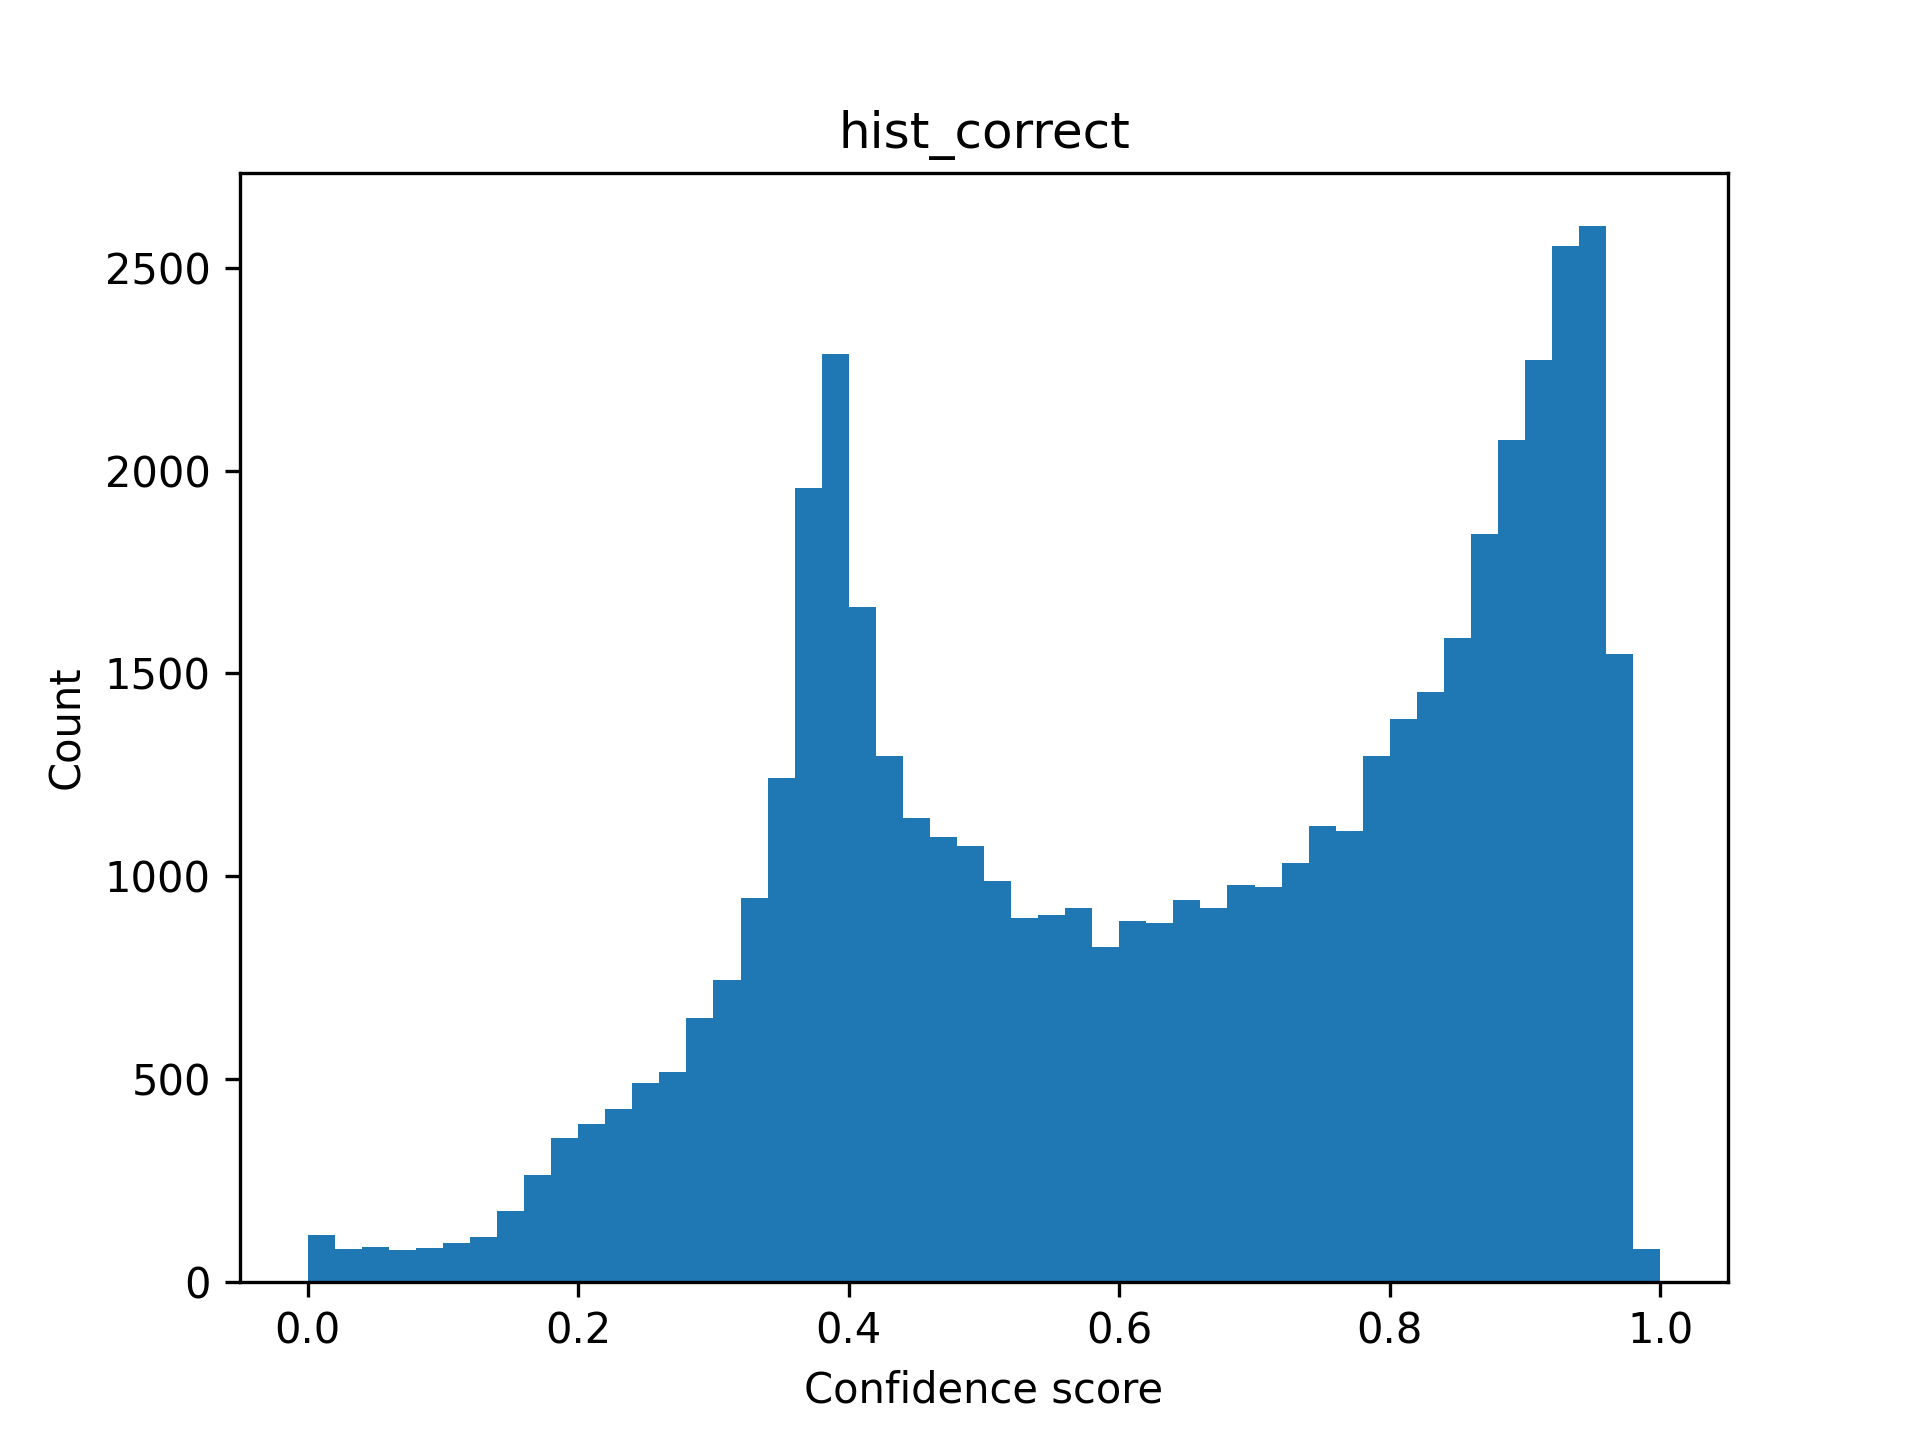

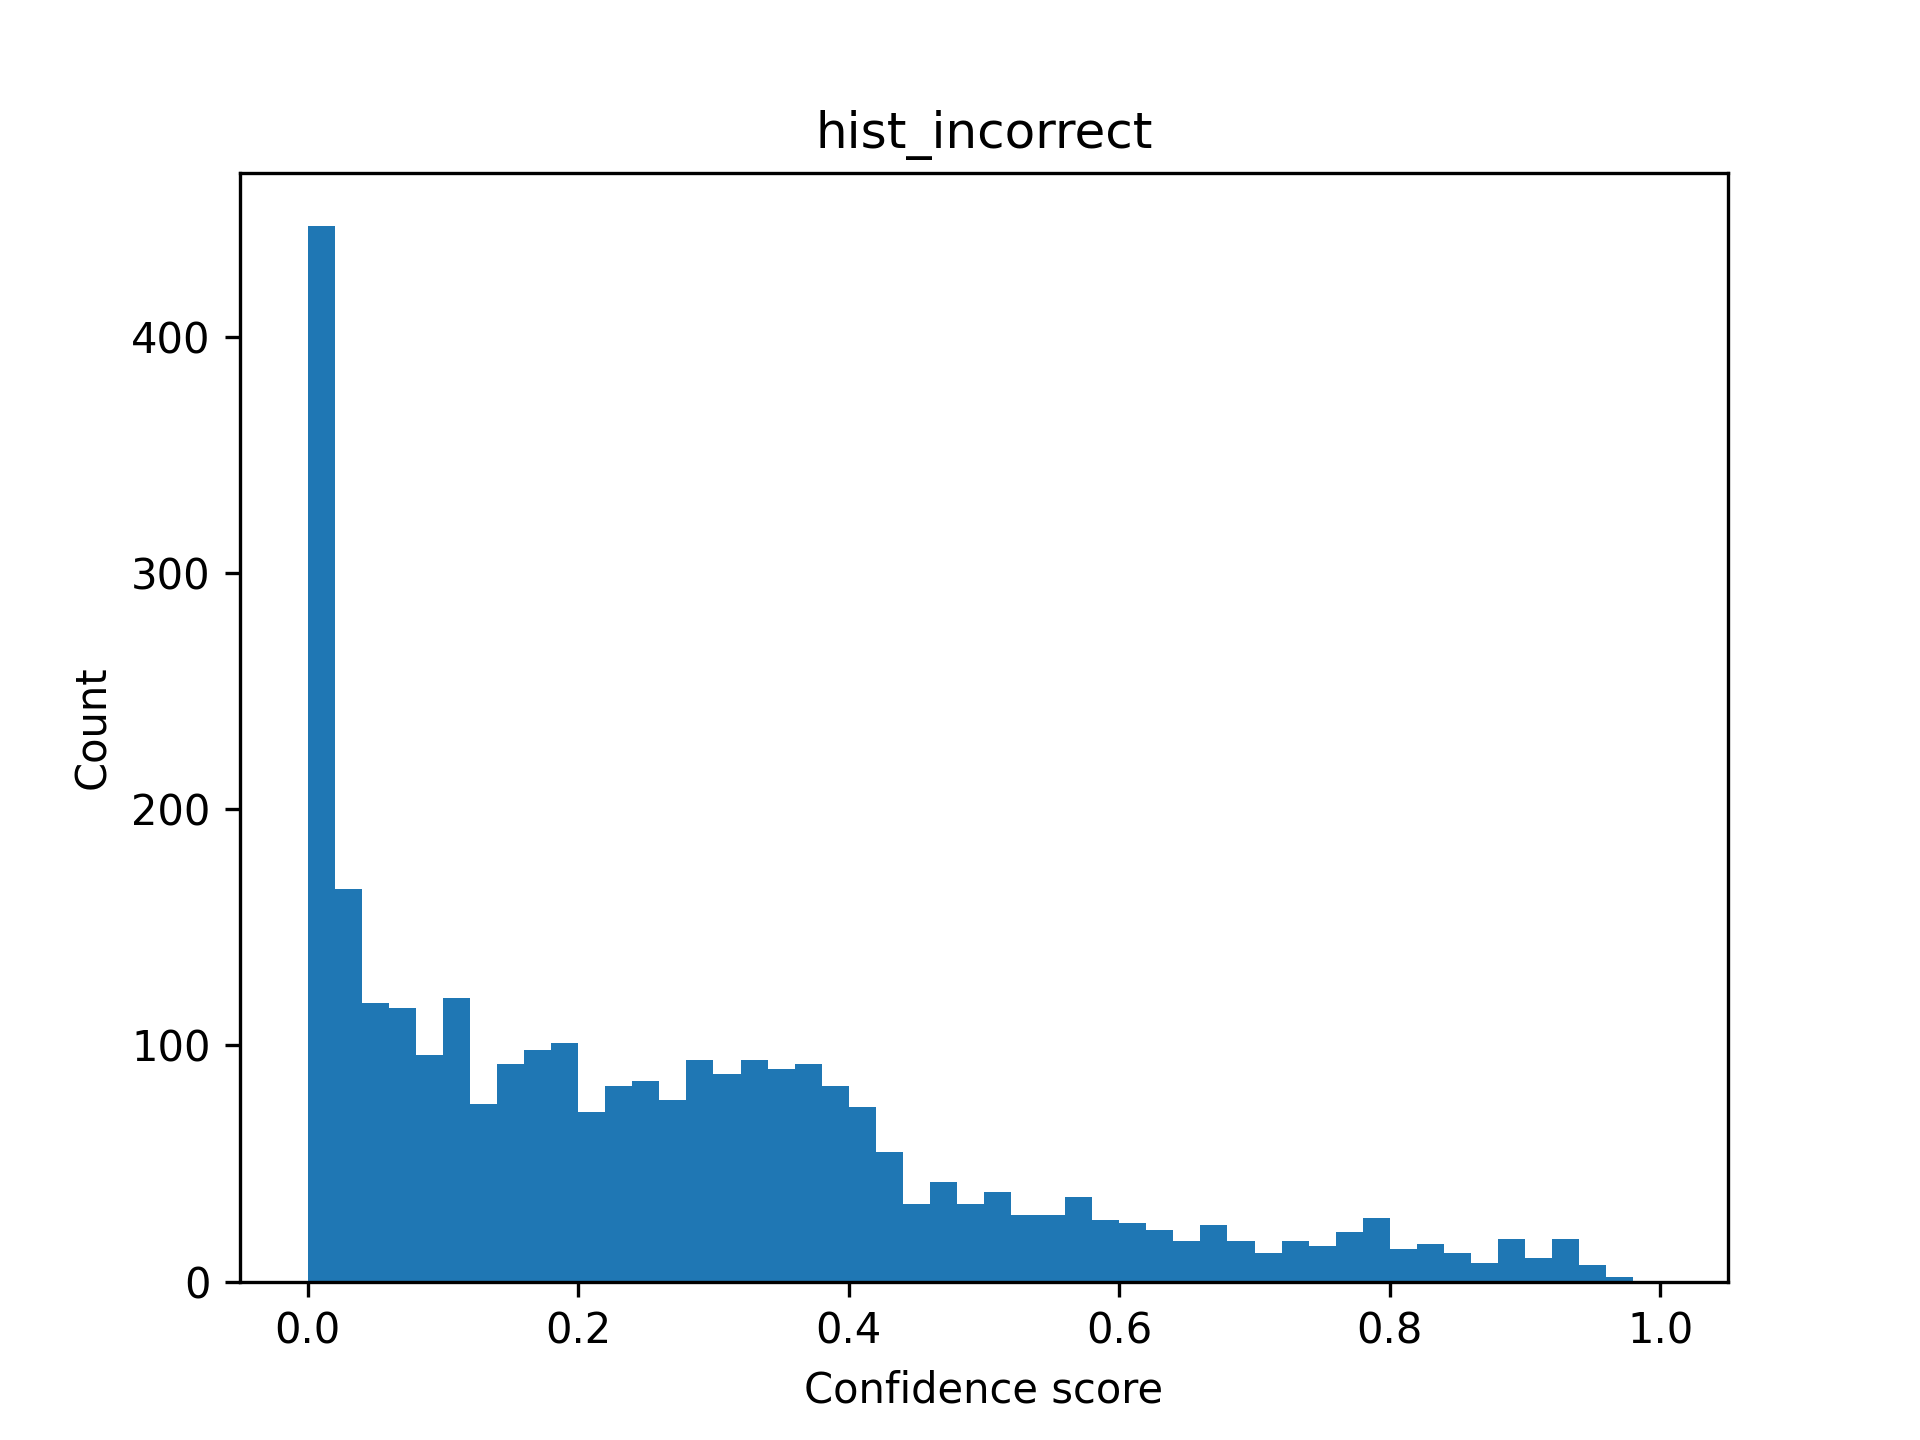

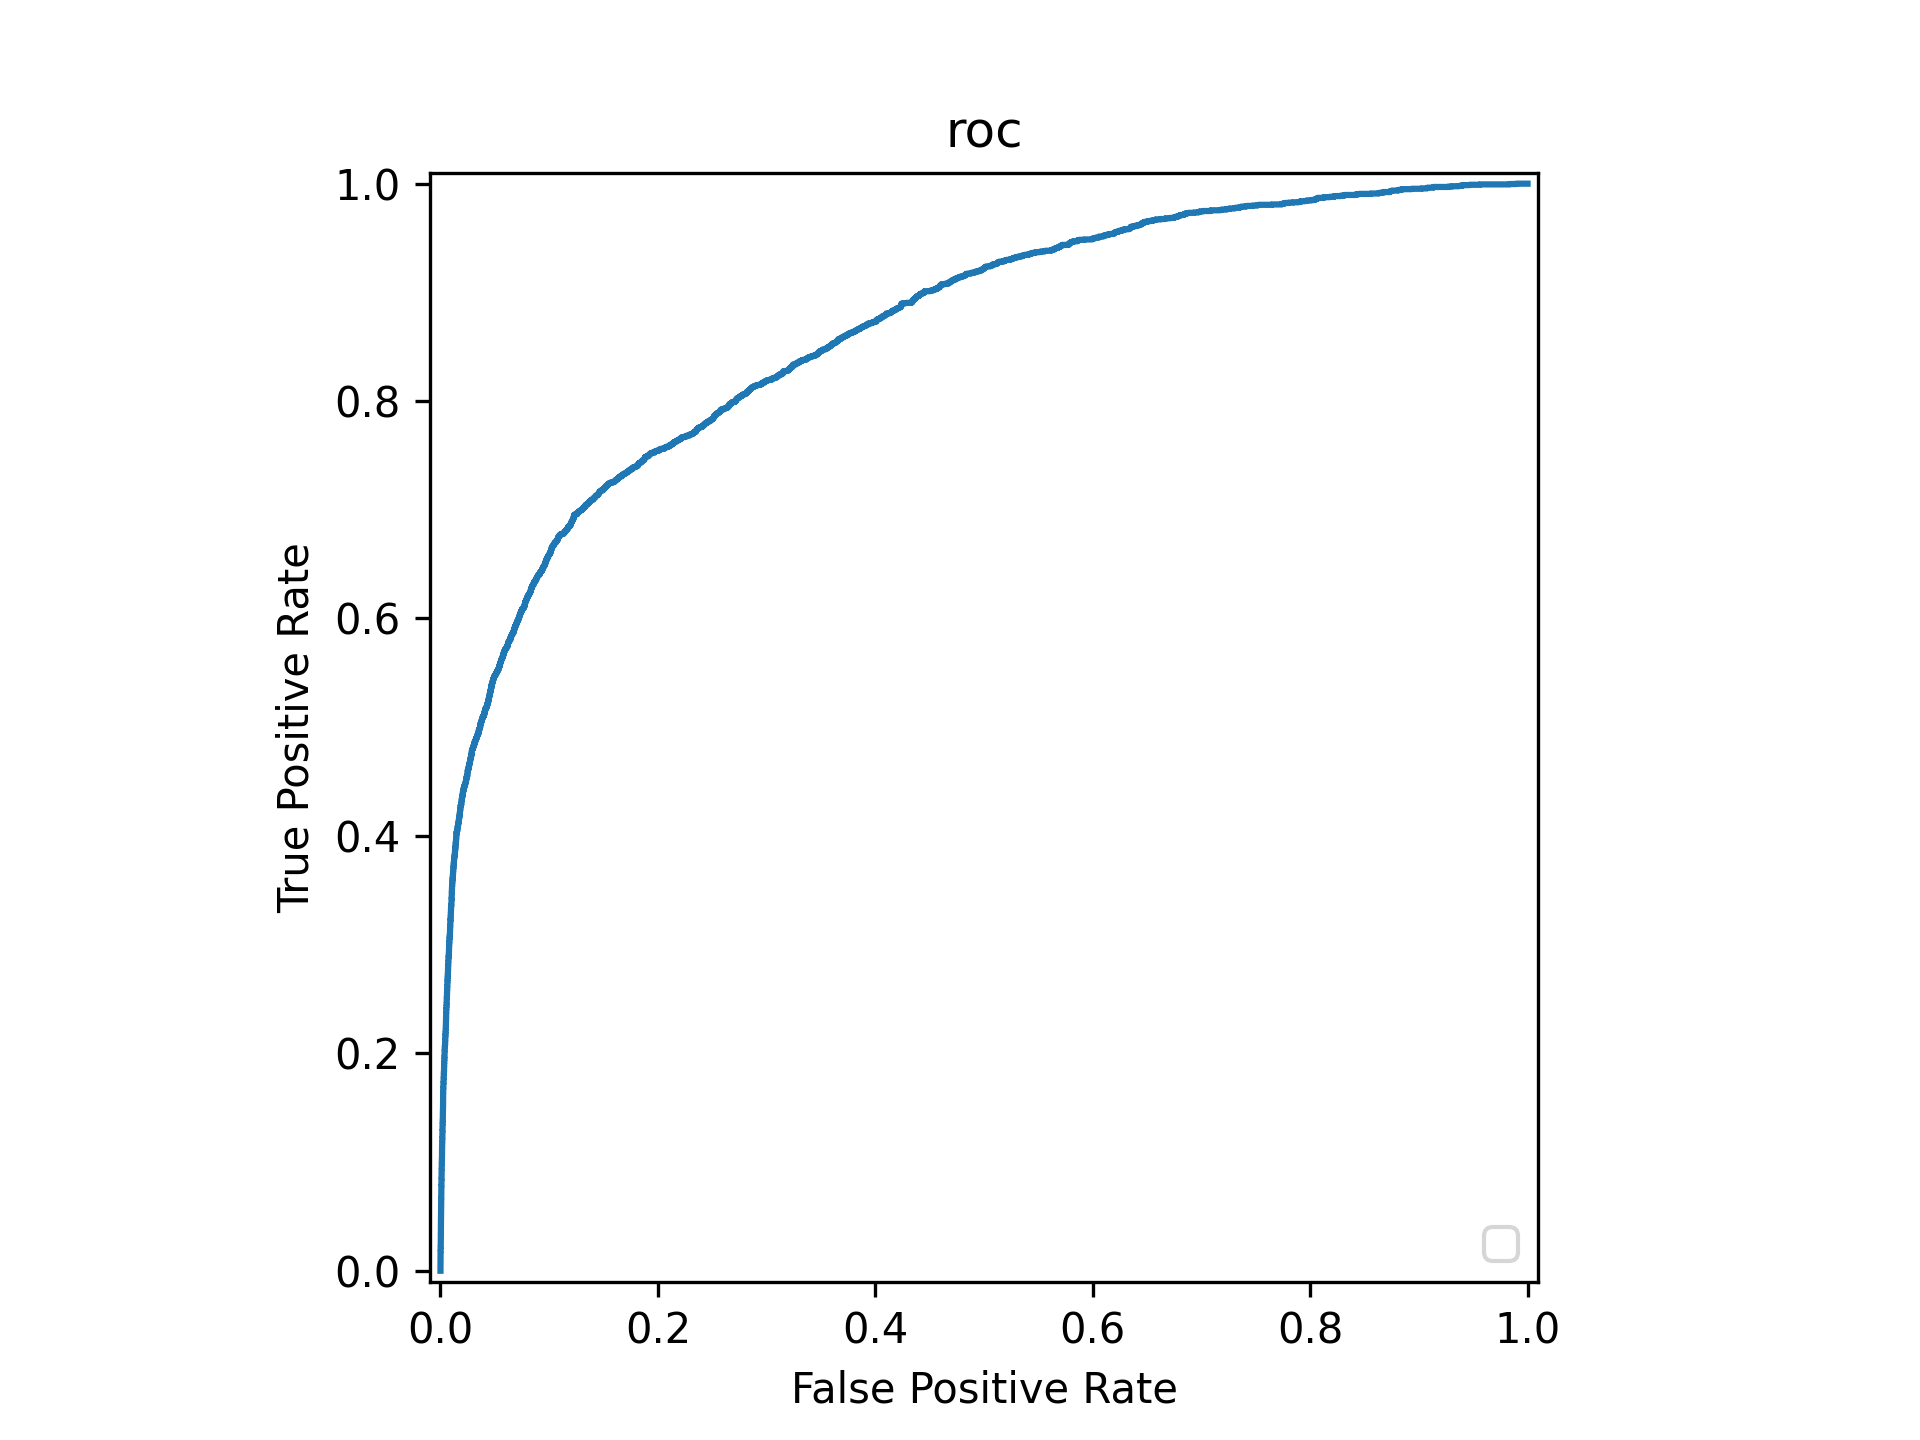

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [34]:
from tempfile import TemporaryDirectory


plot_dir = TemporaryDirectory()
os.makedirs(plot_dir.name, exist_ok=True)

mask_correct = y_true == 1
y_score_correct = y_score[mask_correct]
y_score_incorrect = y_score[~mask_correct]

# histogram of the correct distribution
save_confidence_hist(y_score_correct, plot_dir.name, "hist_correct")
# histogram of the incorrect distribution
save_confidence_hist(y_score_incorrect, plot_dir.name, "hist_incorrect")
# AUC-ROC curve
save_roc_curve(y_true, y_score, plot_dir.name, "roc")


display(
    Image(filename=os.path.join(plot_dir.name, "hist_correct.png"), retina=True),
    Image(filename=os.path.join(plot_dir.name, "hist_incorrect.png"), retina=True),
    Image(filename=os.path.join(plot_dir.name, "roc.png"), retina=True),
)

Optionally, you can look at curves for other metrics ($\mathrm{PR}$, $\mathrm{NT}$, $\mathrm{ECE}$, and $\mathrm{YC}$).

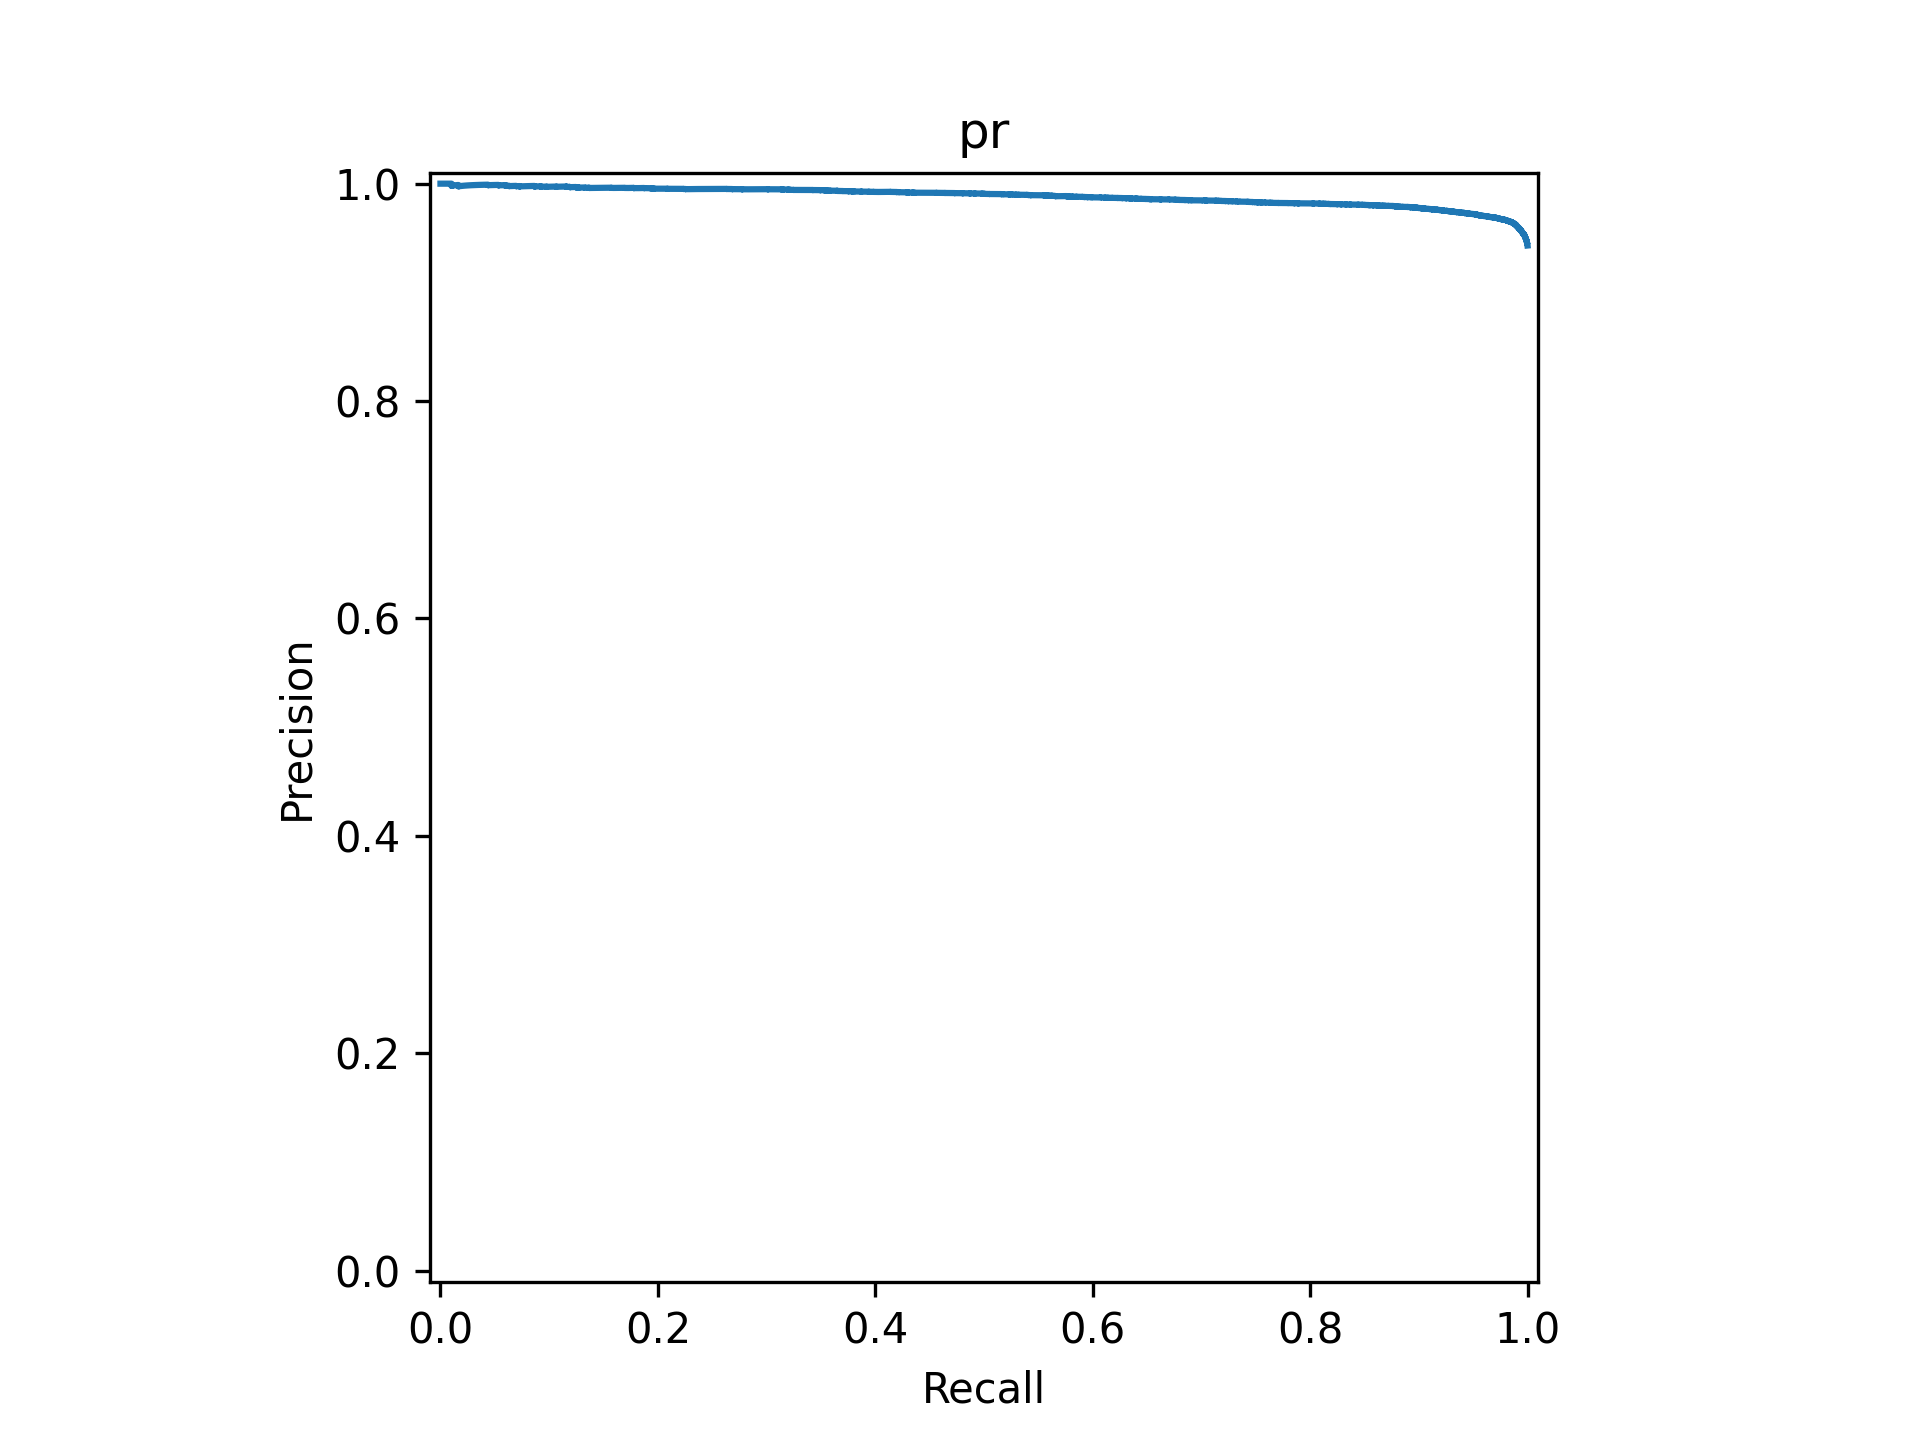

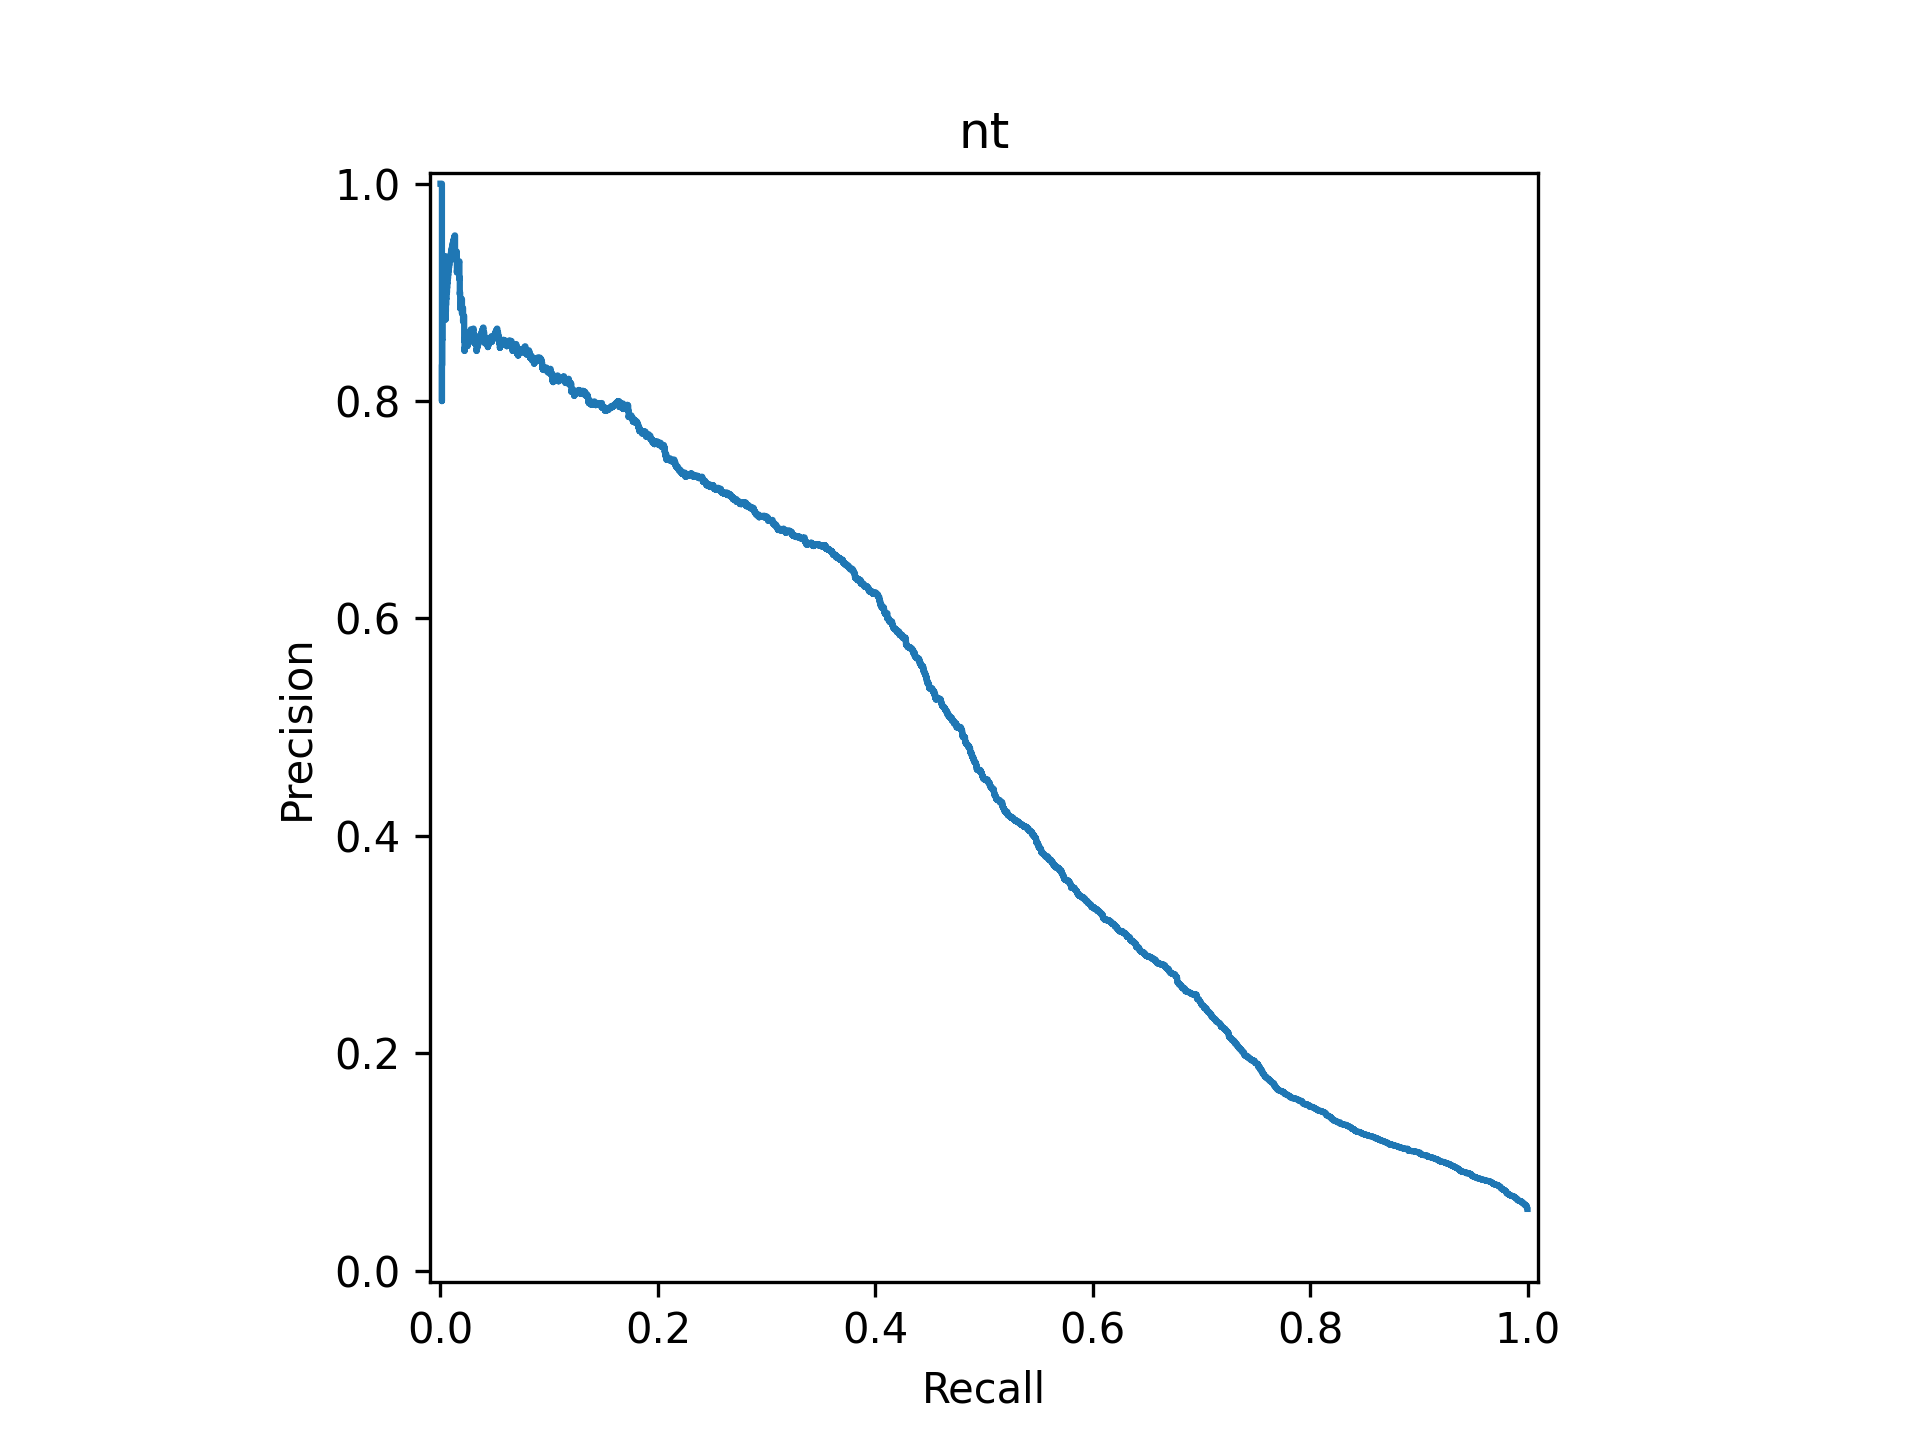

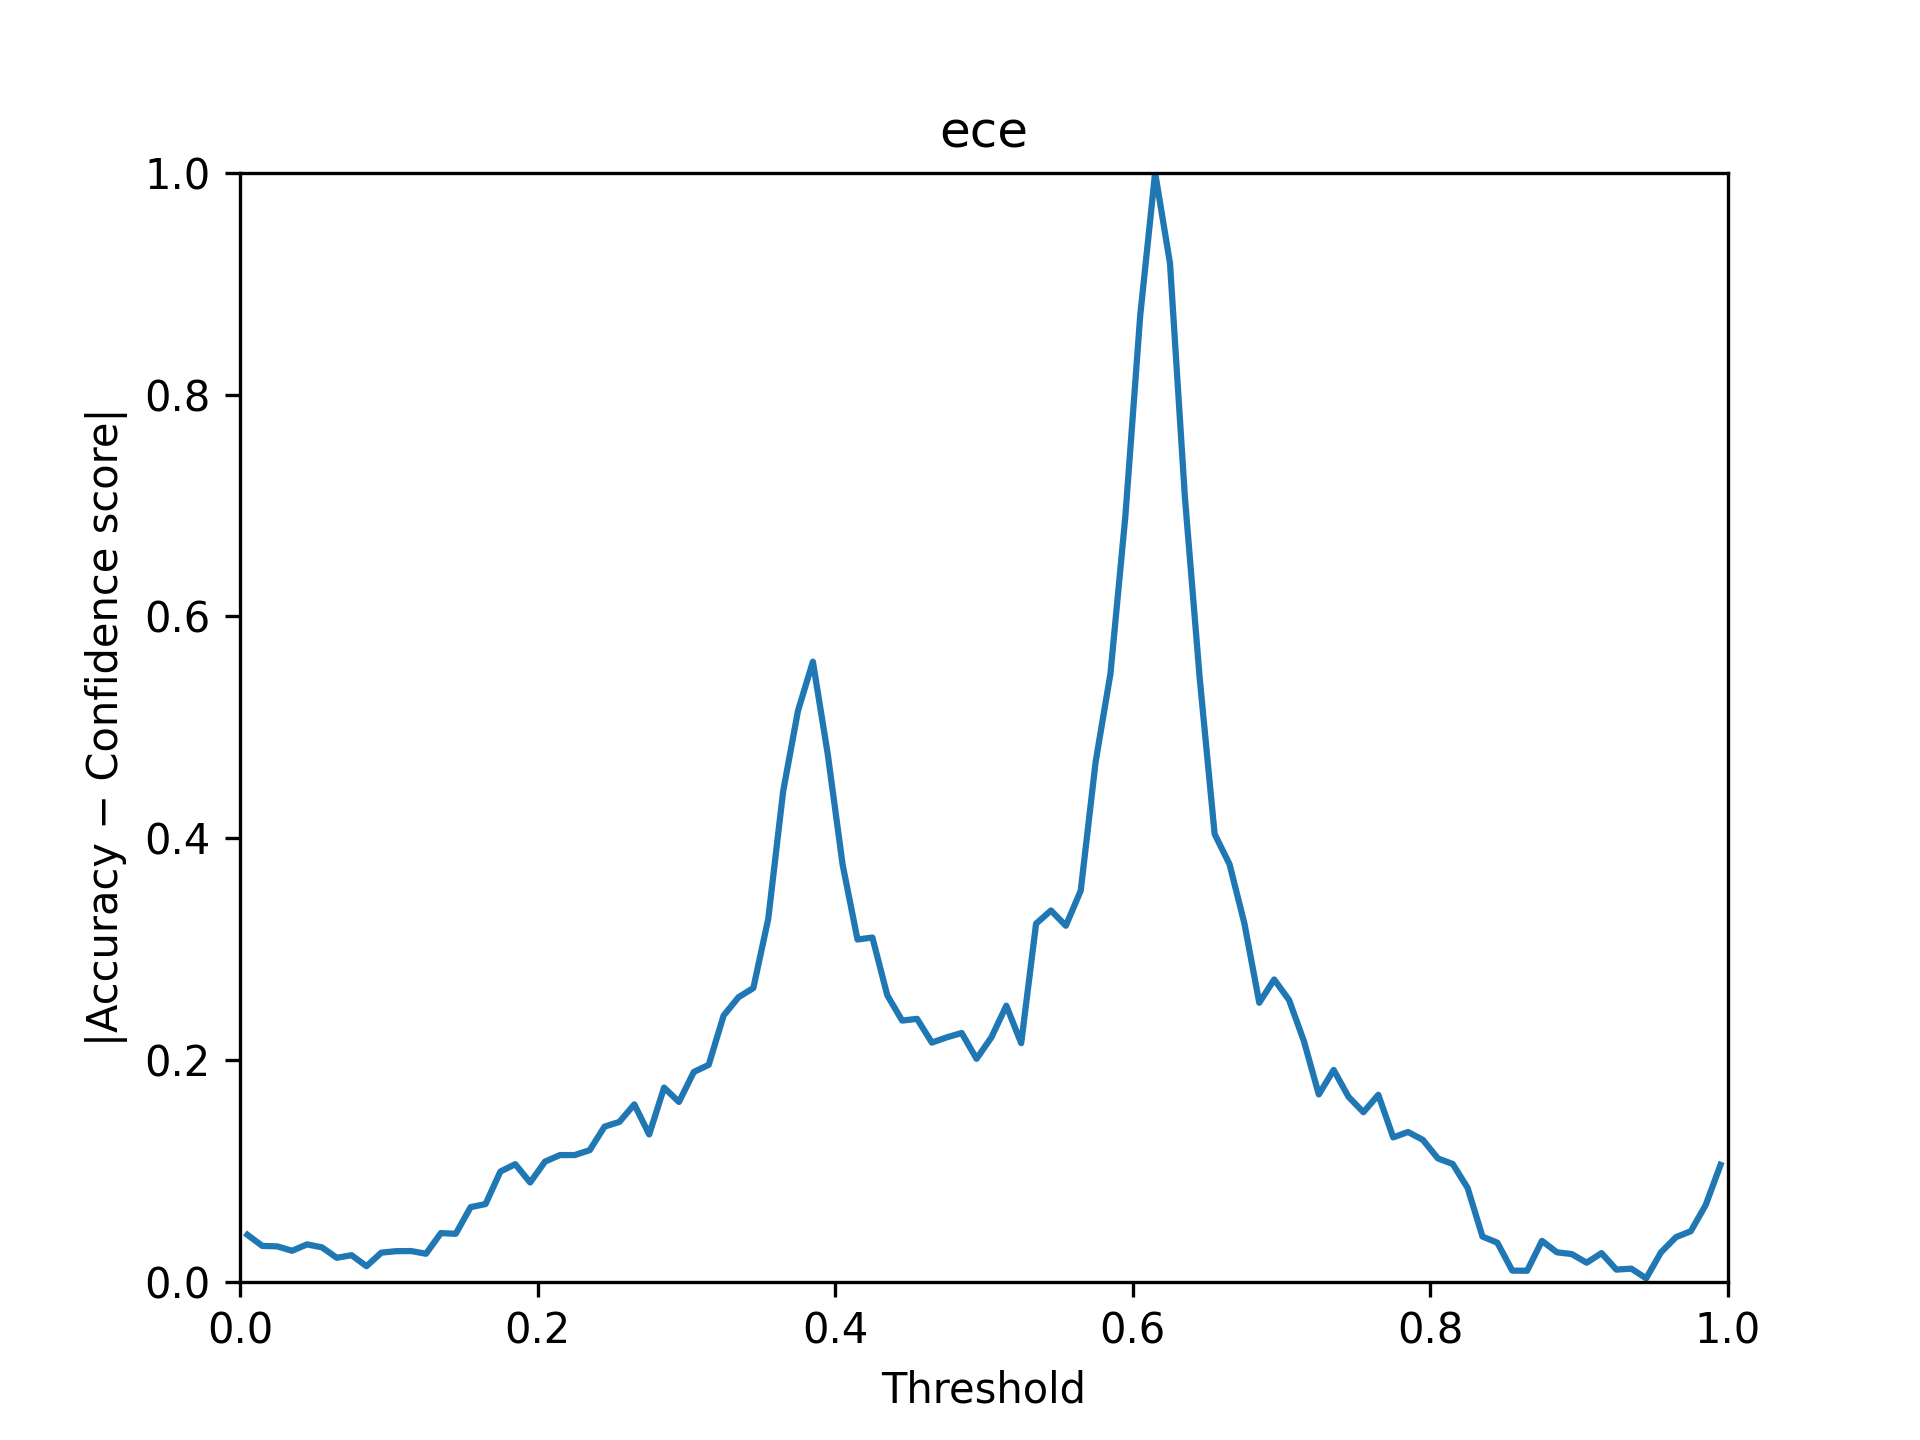

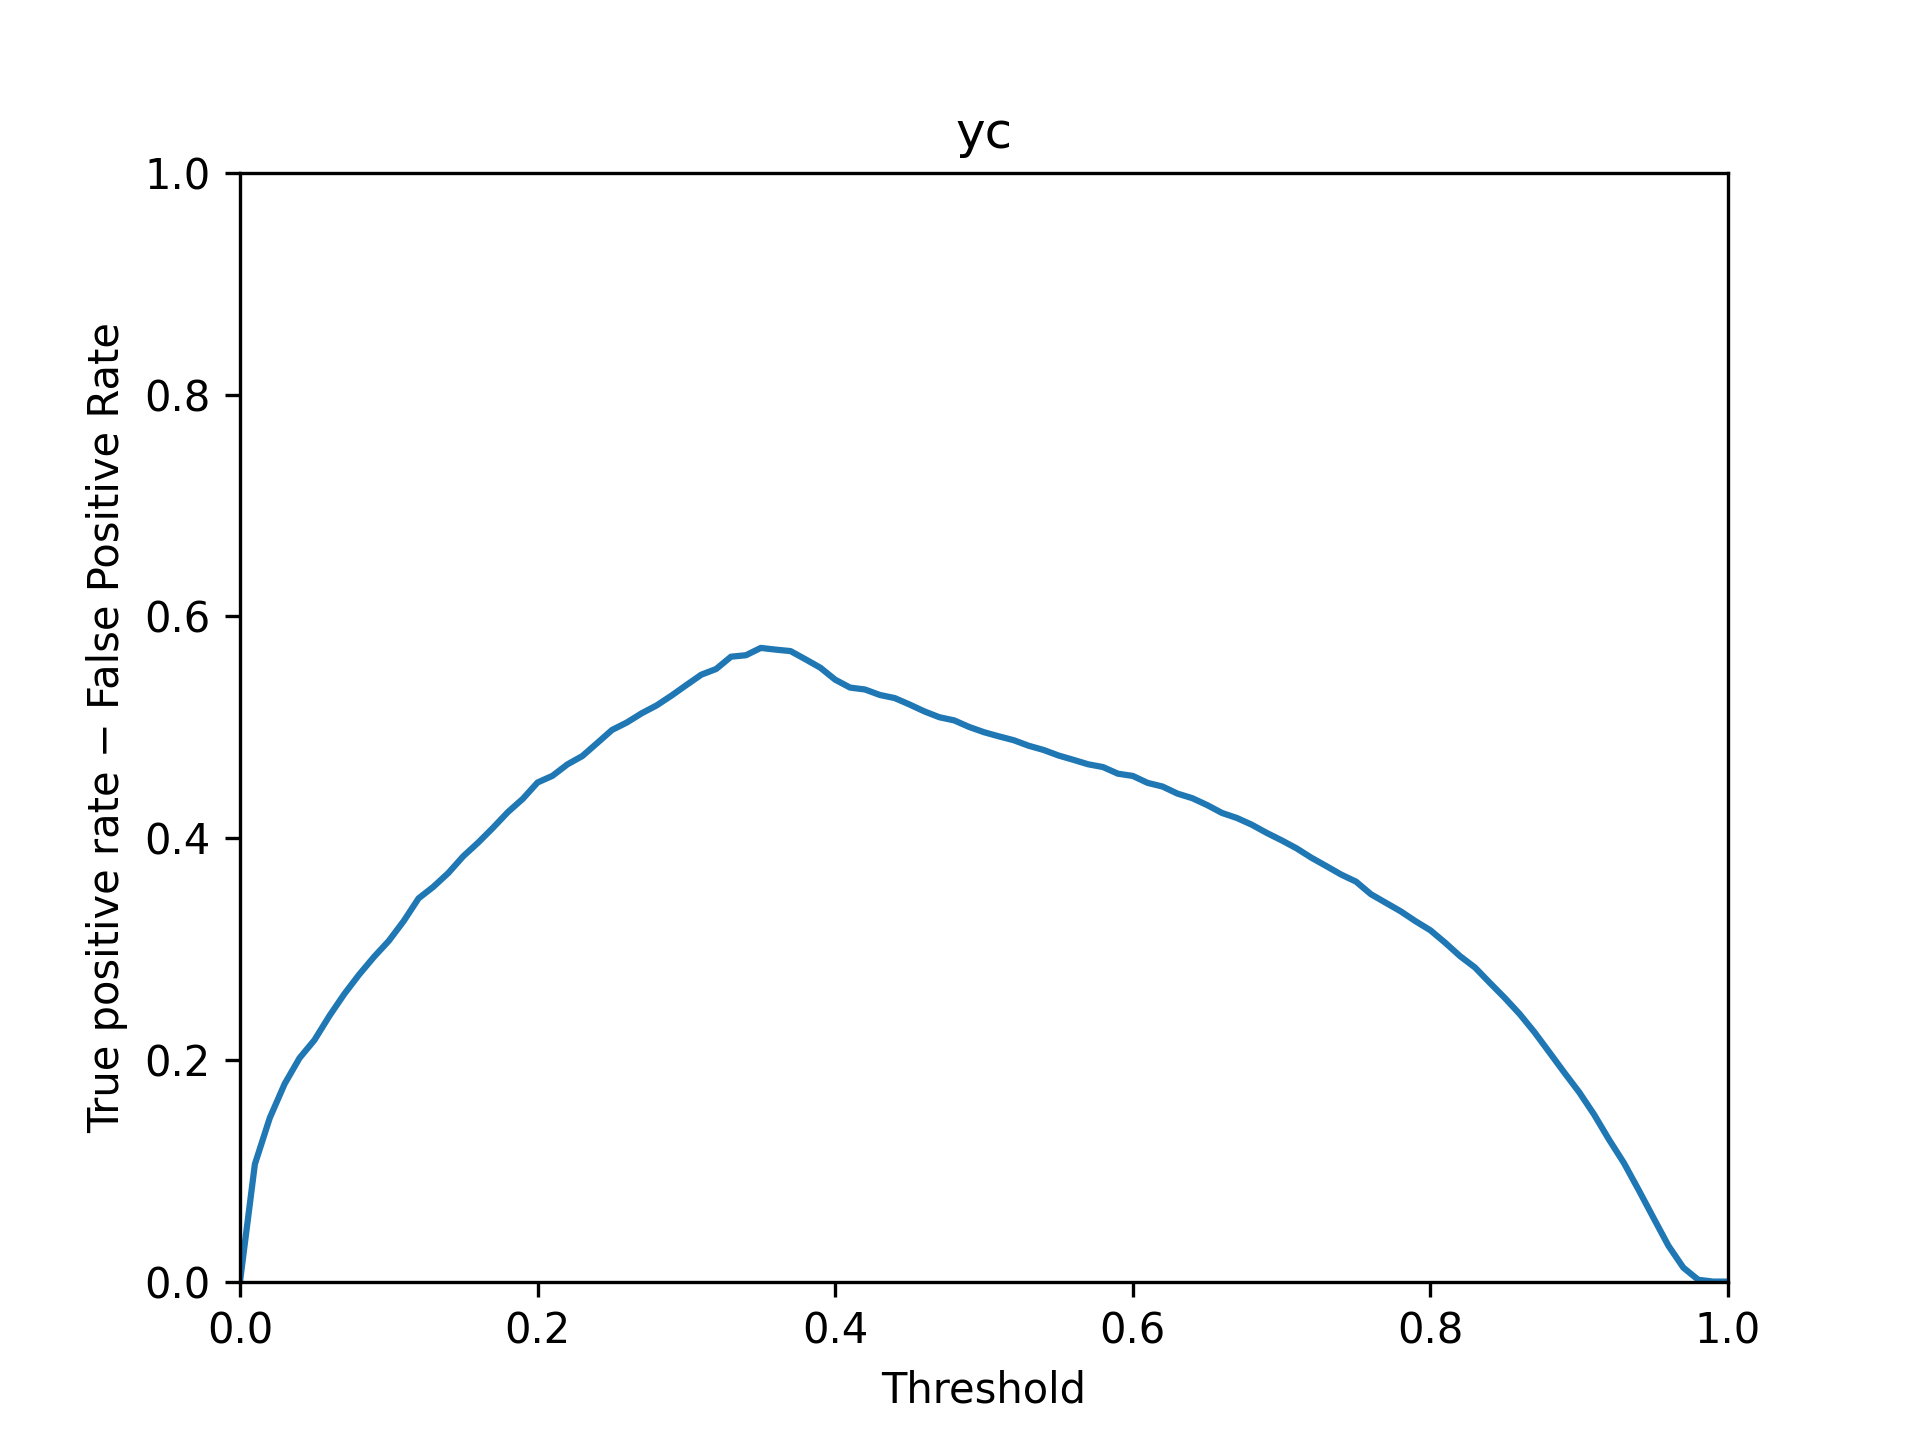

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
# AUC-PR curve
save_pr_curve(y_true, y_score, plot_dir.name, "pr")
# AUC-NT curve
save_nt_curve(y_true, y_score, plot_dir.name, "nt")
# ECE curve
ece_thresholds, ece_values = results_ece[-1]
ece_values /= max(ece_values)
save_custom_confidence_curve(
    ece_thresholds, ece_values, plot_dir.name, "ece", "Threshold", "|Accuracy − Confidence score|"
)
# AUC-YC curve
yc_thresholds, yc_values = result_yc[-1]
save_custom_confidence_curve(
    yc_thresholds, yc_values, plot_dir.name, "yc", "Threshold", "True positive rate − False Positive Rate"
)


display(
    Image(filename=os.path.join(plot_dir.name, "pr.png"), retina=True),
    Image(filename=os.path.join(plot_dir.name, "nt.png"), retina=True),
    Image(filename=os.path.join(plot_dir.name, "ece.png"), retina=True),
    Image(filename=os.path.join(plot_dir.name, "yc.png"), retina=True),
)

You can use `scripts/speech_recognition/confidence/benchmark_asr_confidence.py` to find optimal confidence hyperparameters.

Finding optimal hyperparameters for confidence metrics

In [13]:
file_path = '/home/user01/NeMo/nemo/collections/asr/parts/submodules/rnnt_decoding.py' 

# Read the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Modify the lines
modified_lines = []
for line in lines:
    modified_lines.append(
        line.replace(
            'zip(hyp.timestep, hyp.timestep[1:] + [len(hyp.frame_confidence)])',
            'zip(hyp.timestep.tolist(), hyp.timestep[1:].tolist() + [len(hyp.frame_confidence)])'
        )
    )

# Write the modified lines back to the file
with open(file_path, 'w') as file:
    file.writelines(modified_lines)

In [14]:
!python benchmark_asr_confidence.py \
    model_path=null \
    pretrained_name="stt_en_conformer_transducer_large_ls" \
    dataset_manifest="/home/user01/NeMo/tutorials/asr/WORK_DIR/DATA/test_clean.json" \
    output_dir="/home/user01/NeMo/tutorials/asr/WORK_DIR/OUTPUT" \
    batch_size=4 \
    num_workers=4 \
    cuda="0" \
    amp=True \
    target_level="word" \
    confidence_cfg.exclude_blank=False \
    +HYDRA_FULL_ERROR=1 \
    'grid_params="{\"aggregation\": [\"max\", \"mean\", \"min\", \"prod\"], \"alpha\": [0.25, 0.33, 0.5, 0.67], \"entropy_norm\": [\"exp\", \"lin\"], \"entropy_type\": [\"tsallis\", \"gibbs\", \"renyi\"], \"name\": [\"max_prob\", \"entropy\"]}"'

[NeMo W 2024-08-27 12:46:50 nemo_logging:349] /home/user01/anaconda3/envs/nemo/lib/python3.10/site-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo I 2024-08-27 12:46:50 benchmark_asr_confidence:147] Hydra config: model_path: null
    pretrained_name: stt_en_conformer_transducer_large_ls
    dataset_manifest: /home/user01/NeMo/tutorials/asr/WORK_DIR/DATA/test_clean.json
    output_dir: /home/user01/NeMo/tutorials/asr/WORK_DIR/OUTPUT
    batch_size: 4
    num_workers: 4
    cuda: 0
    amp: true
    audio_type: wav
    target_level: word
    confidence_cfg:
      preserve_frame_confidence: false
      preserve_token_confidence: true
      preserve_word_confidence: true
      exclude_blank: false
      aggregation: min
      tdt_include_duration: false
      metho

In [20]:
import pandas as pd

# Read the CSV file
csv = pd.read_csv("report.csv")

# Create an ExcelWriter object and write the data to an Excel file
with pd.ExcelWriter("report.xlsx") as excel:
    csv.to_excel(excel, index=False)


: 